# En pratique, on cherche un modèle à la fois sensible(Sensbible) et spécifique .

In [79]:
import sys, os
sys.path.append(os.path.abspath('../'))  # permet d’accéder au dossier parent
from src.utils.imports import *
from src.utils.config import CREDITCARD_PATH

In [80]:
df = pd.read_csv(CREDITCARD_PATH)
print(f" Fichier chargé depuis : {CREDITCARD_PATH}")

 Fichier chargé depuis : C:\Users\kadas\Desktop\Fraude\fraudflow\data\creditcard.csv


In [81]:
df=df[["V14","V18","V7","V4","V11","V12","V10","V16","V3","V17","V9","V2","Class", "Amount","Time"]]

# Features et cible
X = df.drop(columns=["Class", "Amount"])
y = df["Class"]

#  Séparation Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=90
)

In [82]:
#  Normalisation non obligatoire ici (XGBoost gère les échelles)
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

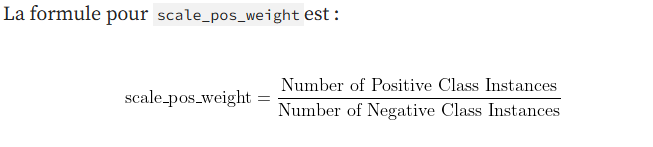

In [83]:
# 2️. Gestion du déséquilibre
# scale_pos_weight = nombre de négatifs / nombre de positifs
scale_pos_weight = sum (y_train == 0 ) / sum (y_train == 1 ) 
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

scale_pos_weight = 577.29


scale_pos_weight paramètre permet de corriger les déséquilibres entre les ensembles de données. Il contribue à équilibrer les classes positives et négatives, en accordant plus d'importance à la classe minoritaire.

Parmi tous les cas réellement positifs (ex : toutes les fraudes réelles, tous les malades, tous les clients qui ont vraiment quitté), 87 % ont été correctement identifiés par le modèle.

In [ ]:
# 3️. Modèle XGBoost

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=90,
    n_jobs=-1,
    use_label_encoder=False
)

# Fit 
xgb.fit(
    X_train_xgb, y_train,
    eval_set=[(X_test_xgb, y_test)], # suivi sur le jeu de test
    verbose=False
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [ ]:
# 5️. Prédictions
y_pred_xgb = xgb.predict(X_test_xgb)  # seuil par défaut = 0.5
y_proba_xgb = xgb.predict_proba(X_test_xgb)[:, 1] # probas de la classe 1 (fraude)

In [87]:
#  Choix du seuil personnalisé 
seuil = 0.1
y_pred_custom = (y_proba_xgb >= seuil).astype(int)    

In [88]:
# 6️. Évaluation

auprc_xgb = average_precision_score(y_test, y_proba_xgb)
print(f"\n AUPRC (Precision-Recall) : {auprc_xgb:.4f}")

#  Rapport avec seuil par défaut (0.5)
print("\n=== Classification Report (seuil par défaut = 0.5) ===")
print(classification_report(y_test, y_pred_xgb, digits=4))

#  Rapport avec ton seuil personnalisé (0.1)
print(f"\n=== Classification Report (seuil personnalisé = {seuil}) ===")
print(classification_report(y_test, y_pred_custom, digits=4))


 AUPRC (Precision-Recall) : 0.7963

=== Classification Report (seuil par défaut = 0.5) ===
              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     56864
           1     0.8370    0.7857    0.8105        98

    accuracy                         0.9994     56962
   macro avg     0.9183    0.8927    0.9051     56962
weighted avg     0.9994    0.9994    0.9994     56962


=== Classification Report (seuil personnalisé = 0.1) ===
              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996     56864
           1     0.7647    0.7959    0.7800        98

    accuracy                         0.9992     56962
   macro avg     0.8822    0.8977    0.8898     56962
weighted avg     0.9992    0.9992    0.9992     56962



L’abaissement du seuil n’apporte qu’un gain marginal (+1 % de recall),
au prix d’une légère baisse de précision.
Donc ici, le seuil 0.5 est déjà très équilibré : XGBoost gère mieux le compromis que Random Forest.

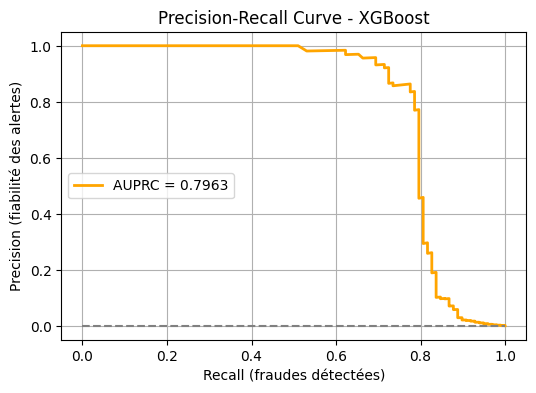

In [69]:
# 7️. Courbe Precision-Recall

precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, color='orange', lw=2, label=f"AUPRC = {auprc_xgb:.4f}")
plt.plot([0,1], [np.mean(y_test)]*2, linestyle='--', color='gray')
plt.title("Precision-Recall Curve - XGBoost")
plt.xlabel("Recall (fraudes détectées)")
plt.ylabel("Precision (fiabilité des alertes)")
plt.legend()
plt.grid(True)
plt.show()

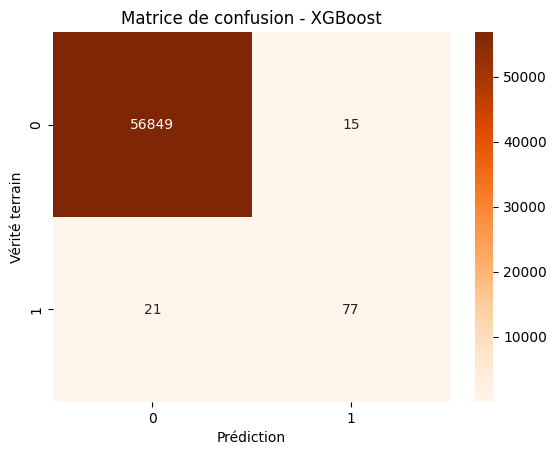

In [93]:
# 8️. Matrice de confusion

# Génère la matrice
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("Matrice de confusion - XGBoost")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

In [94]:
# Extraction des éléments
VN = cm_xgb[0, 0]
FP = cm_xgb[0, 1]
FN = cm_xgb[1, 0]
VP = cm_xgb[1, 1]

# Calcul des métriques
specificite = VN / (VN + FP)
sensibilite = VP / (VP + FN)
precision = VP / (VP + FP)

print(f"Spécificité : {specificite:.4f}")
print(f"Sensibilité (Recall) : {sensibilite:.4f}")
print(f"Précision : {precision:.4f}")

Spécificité : 0.9997
Sensibilité (Recall) : 0.7857
Précision : 0.8370


In [71]:
# 9️. AUPRC Train vs Test

y_train_proba_xgb = xgb.predict_proba(X_train_xgb)[:, 1]
auprc_train_xgb = average_precision_score(y_train, y_train_proba_xgb)
print(f"\nAUPRC Train: {auprc_train_xgb:.4f} | AUPRC Test: {auprc_xgb:.4f}")


AUPRC Train: 0.9975 | AUPRC Test: 0.7963
